![](network.png)

### Matrix/vector dimensions

$$
k\text{-th layer size (number of neurons)}: [D_k \times 1]
$$

$$
\text{input: }[x] = [D_0 \times 1],
$$

$$
\text{output: }[y] = [z^L] = [D_L \times 1],
$$

$$
\text{k-th layer weight matrix: }[W^k] = [D_k \times D_{k-1}],
$$

$$
\text{k-th layer bias: }[b^k] = [D_k \times 1].
$$

### Forward propagation equations:

Activations of the first hidden layer (for neuron $j$):


$$\begin{equation} a_j^1 = \sum_{i=1}^{D_0} \omega_{ji}^1 \cdot x_i + b_j^1 \end{equation},$$

$$z_j^1 = h(a_j^1),$$

$$...$$

Activations of the k-th layer:

$$a_j^k = \sum_{i=1}^{D_{k-1}} \omega_{ji}^k \cdot z_i^{k-1} + b_j^k,$$

$$z_j^k = h(a_j^k),$$

$$...$$

Activations of the last layer:

$$a_j^L = \sum_{i=1}^{D_{L-1}} \omega_{ji}^L \cdot z_i^{L-1} + b_j^L,$$

$$z_j^L = h(a_j^L) = h_{\mathrm{out}}(a_j^L),$$

For classification, the final activation $h_{\mathrm{out}}(a_j^L) = \log\left[\mathrm{softmax}\left(a_j^L\right)\right] = \log(p)$ is the log of the probability distribution.

Cross-entropy loss can be written as $\mathcal{L} = -\mathrm{target} \cdot \log\left(p\right) = -\mathrm{target}\cdot z^L$, where $\mathrm{target}$ is the target probability distribution. Here we take it to be one-hot vector with $t$-th index (target class) set to 1.

Loss then becomes: 
$$\mathcal{L} = -\begin{pmatrix}0 & 0 & \cdots & 1 & 0 & \cdots & 0\end{pmatrix} \cdot z^L = -\log\left[\mathrm{softmax}\left(a_t^L\right)\right] = -a_t^{L} + \log\left[\sum_{j=1}^{D_L}\exp\left(a_j^L\right)\right] \tag{$\star$}$$ (negative log of the predicted probability of the correct class).

### Backward propagation equations

Define

$$\delta_j^k = \frac{\partial \mathcal{L}}{\partial a_j^k},$$

Then last layer delta:

$$\delta_j^L = -\mathrm{kronecker}(t, j) + \mathrm{softmax}\left(a_j^L\right),$$

Second-to-last layer delta:

$$\delta_j^{L-1} = \frac{\partial \mathcal{L}}{\partial a_j^{L-1}} = \sum_{i=1}^{D_L}\frac{\partial \mathcal{L}}{\partial a_i^{L}} \cdot \frac{\partial a_i^{L}}{\partial a_j^{L-1}},$$

Sum needed, because second-to-last layer $j$-th neuron affects the loss through every last layer neuron. Continuing,

$$\delta_j^{L-1} = \sum_{i=1}^{D_L} \delta_i^L h'\left(a_j^{L-1}\right)\cdot \omega_{ij}^{L},$$

Weight gradient for k-th layer:

$$\frac{\partial \mathcal{L}}{\partial{\omega^k_{ji}}} = \frac{\partial \mathcal{L}}{\partial{a_j^k}}\cdot \frac{\partial{a_j^k}}{\partial{\omega_{ji}^k}} = \delta_j^k \cdot h\left(a_i^{k-1}\right),$$

Bias gradient for k-th layer:

$$\frac{\partial \mathcal{L}}{\partial b^k_j} = \frac{\partial \mathcal{L}}{\partial{a_j^k}} \cdot \frac{\partial a_j^k}{\partial b_j^k} = \delta^k_j.$$

### Forward propagation (in matrix form)

$$a^k = W^k \cdot z^{k-1} + b^k, \qquad a^0 = z^0 = x,$$

$$z^k = h(a^k).$$

### Backward propagation (in matrix form)

$$\delta^L = \mathrm{softmax}\left(a^L\right) - \begin{pmatrix}0 & 0 & \cdots & 0 & 1 & 0 & \cdots & 0 \end{pmatrix}^T \\ = \exp\left(z^L\right) - \begin{pmatrix}0 & 0 & \cdots & 0 & 1 & 0 & \cdots & 0 \end{pmatrix}^T \text{, where only the $t$-th element in the second vector is non-zero.} \tag{$\star\star$}$$

$$\delta^{k-1} = W^k \cdot \delta^k \odot h'\left(a^{k-1}\right),$$

$$ \frac{\partial \mathcal{L}}{\partial W^k} = \delta^k \cdot h\left[\left(a^{k-1}\right)^T\right],$$

$$ \frac{\partial \mathcal{L}}{\partial b^k} = \delta^k.$$

### log-sum-exp trick for numeric stability

$$\log\left[\sum_j \exp\left(a_j\right)\right] = c + \log\left[\sum_j \exp\left(a_j - c\right)\right], \,\, \forall c \tag{$\star\star\star$}$$

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons

In [2]:
class Network:
    def __init__(self):
        
        D0 = 2    # input size
        D1 = 2    # first hidden layer size
        D2 = 3    # second hidden layer size
        D3 = 4    # output size
        
        self.lr = 5e-2    # learning rate
        self.EPOCHS = 500
        self.BATCH_SIZE = 32
        
        # weight matrices
        self.W1 = np.random.randn(D1, D0) / np.sqrt(D0)
        self.W2 = np.random.randn(D2, D1) / np.sqrt(D1)
        self.W3 = np.random.randn(D3, D2) / np.sqrt(D2)

        # biases
        self.b1 = np.random.randn(D1, 1) / np.sqrt(D0)
        self.b2 = np.random.randn(D2, 1) / np.sqrt(D1)
        self.b3 = np.random.randn(D3, 1) / np.sqrt(D2)
        
        self.D3 = D3

    def h(self, x, layer, derive=False):
        """ activation function """
        
        if layer == "output":
            # log-softmax
            xmax = x.max(axis=0, keepdims=True)
            # log-sum-exp trick (equation (***))
            return x - xmax - np.log(np.sum(np.exp(x - xmax), axis=0, keepdims=True))

        # else, sigmoid
        sigma = 1 / ((1 + np.exp(-x)))
        if derive:
            return sigma*(1 - sigma)

        return sigma

    def forward(self, x):
        x = self.W1.dot(x) + self.b1
        x = self.h(x, "hidden")
        
        x = self.W2.dot(x) + self.b2
        x = self.h(x, "hidden")
        
        x = self.W3.dot(x) + self.b3
        x = self.h(x, "output")
        
        return x
    
    def compute_loss(self, prediction, target):
        """ categorical cross-entropy"""
        loss = -np.diag(target.T.dot(prediction)) # equation (*)

        return np.sum(loss)
    
    def one_hot(self, labels):
        size_batch = len(labels)
        onehot = np.zeros((self.D3, size_batch))
        onehot[labels, np.arange(size_batch)] = 1

        return onehot


    def train(self, x_train, y_train, x_test, y_test):
        size_train = len(x_train)
        size_test = len(x_test)
        indices = np.arange(size_train)

        loss_train = []
        loss_test = []
        for _ in tqdm(range(self.EPOCHS), "training"):
            np.random.shuffle(indices)
            x_train = x_train[indices]
            y_train = y_train[indices]

            epoch_loss = 0
            for i in range(0, size_train, self.BATCH_SIZE):
                x = x_train[i:i+self.BATCH_SIZE].T
                y = y_train[i:i+self.BATCH_SIZE]

                # forward propagation
                a1 = self.W1.dot(x) + self.b1
                z1 = self.h(a1, "hidden")

                a2 = self.W2.dot(z1) + self.b2
                z2 = self.h(a2, "hidden")

                a3 = self.W3.dot(z2) + self.b3
                z3 = self.h(a3, "output")
                
                # onehot is matrix of one-hot vectors for each target sample in the batch
                onehot = self.one_hot(y)
                epoch_loss += self.compute_loss(z3, onehot)

                delta3 = np.exp(z3) - onehot # equation (**)
                delta2 = self.W3.T.dot(delta3) * self.h(a2, "hidden", derive=True)
                delta1 = self.W2.T.dot(delta2) * self.h(a1, "hidden", derive=True)

                dW3 = delta3.dot(self.h(a2.T, "hidden"))
                dW2 = delta2.dot(self.h(a1.T, "hidden"))
                dW1 = delta1.dot(self.h(x.T, "hidden"))
                
                db3 = delta3.mean(axis=1, keepdims=True)
                db2 = delta2.mean(axis=1, keepdims=True)
                db1 = delta1.mean(axis=1, keepdims=True)
                
                parameters = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
                grads = [dW1, dW2, dW3, db1, db2, db3]

                for param, grad in zip(parameters, grads):
                    param -= self.lr * grad

            pred_test = self.forward(x_test.T)
            onehot_test = self.one_hot(y_test)
            test_loss = self.compute_loss(pred_test, onehot_test)

            loss_test.append(test_loss / size_test)
            loss_train.append(epoch_loss / size_train)

        return loss_train, loss_test

## Data loading

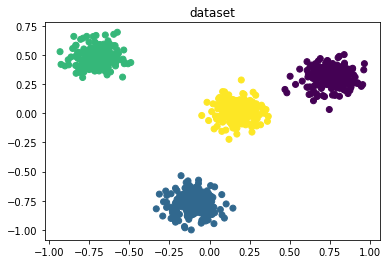

In [3]:
x_data, y_data = make_blobs(n_samples = 800, centers=4, random_state=8888)
# x_data, y_data = make_moons(n_samples = 800, noise=0.05)

# normalize
x_data = x_data / np.abs(x_data).max()

size_data = len(x_data)
size_train = int(0.75 * size_data)

ix = np.arange(size_data)
np.random.shuffle(ix)

x_train = x_data[ix[:size_train]]
y_train = y_data[ix[:size_train]]

x_test = x_data[ix[size_train:]]
y_test = y_data[ix[size_train:]]

plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data)
plt.title("dataset")
plt.show()

## Training

In [4]:
model = Network()
loss_train, loss_test = model.train(x_train, y_train, x_test, y_test)

training: 100%|██████████| 500/500 [00:03<00:00, 148.21it/s]


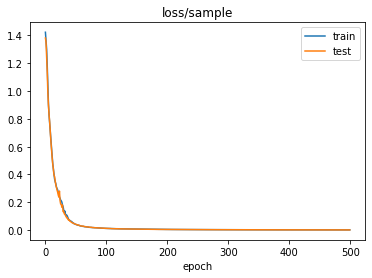

In [5]:
plt.plot(loss_train, label="train")
plt.plot(loss_test, label="test")
plt.legend()
plt.title("loss/sample")
plt.xlabel("epoch")
plt.show()

## Decision boundaries

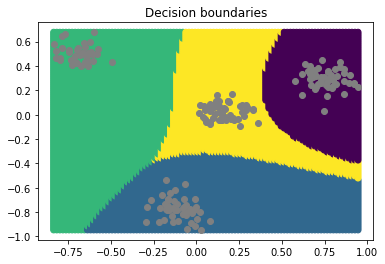

In [6]:
points = 100

x = np.linspace(x_test[:,1].min(), x_test[:,1].max(), points)
y = np.linspace(x_test[:,0].min(), x_test[:,0].max(), points)

[X, Y] = np.meshgrid(x, y)
C = np.zeros_like(X)

for j in range(points):
    for i in range(points):
        xji = X[j][i]
        yji = Y[j][i]
        pred = model.forward(np.array([[yji, xji]]).T).argmax()
        C[j][i] = pred
        
plt.scatter(Y, X, c=C)
plt.scatter(x_test[:,0], x_test[:,1], c="gray")
plt.title("Decision boundaries")
plt.show()